In [1]:
import sys
sys.path.insert(1, '../functions')
from gk import gk
from mwrko import mwrko
from gko import gko
from method import method
from method2 import method2
from compute_sin2 import compute_sin2
import math 

In [2]:
# importing necessary libraries
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from scipy import sparse
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from itertools import permutations

## Gaussian System

In [3]:
# setting up data
A = np.random.randn(5000,500)
A = normalize(A, axis=1, norm='l2')
m,n = A.shape
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [4]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
#U,S,V = np.linalg.svd(D)
#DS2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [5]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
#old_LHk_gko = S2_min / max_angle_g
LHk_gko = S2_min
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [6]:
# Run algorithms
gk_gaussian = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gaussian = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gaussian = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

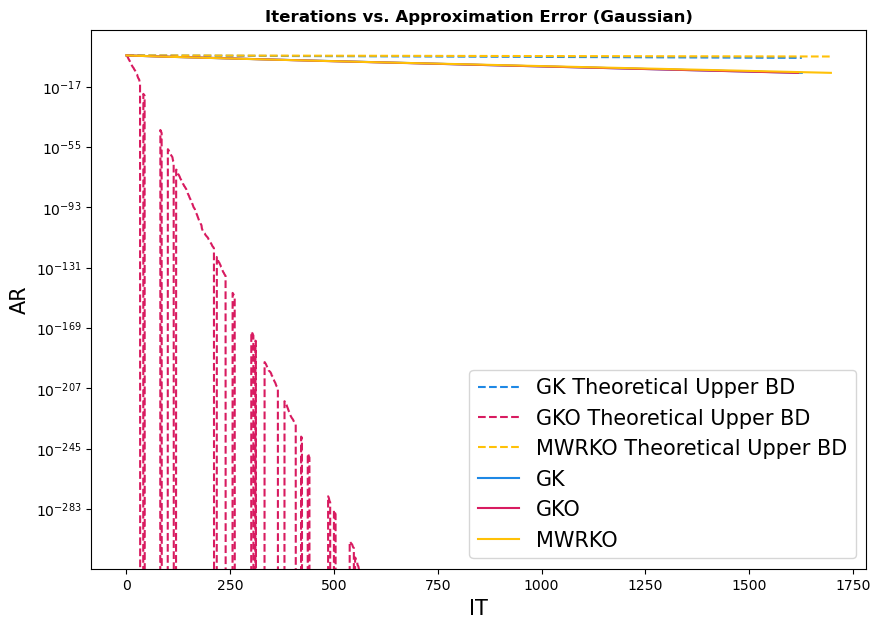

In [7]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gaussian[2])), gk_gaussian[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(gko_gaussian[2])), gko_gaussian[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(mwrko_gaussian[2])), mwrko_gaussian[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
plt.semilogy(np.arange(gk_gaussian[0]), gk_gaussian[1], color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
plt.semilogy(np.arange(gko_gaussian[0]), gko_gaussian[1], linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
plt.semilogy(np.arange(mwrko_gaussian[0]), mwrko_gaussian[1], linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
# labels
plt.xlabel('IT', fontsize = 15)
plt.ylabel('AR', fontsize = 15)
plt.title('Iterations vs. Approximation Error (Gaussian)', fontweight="bold")
plt.legend(fontsize="15")
plt.show()

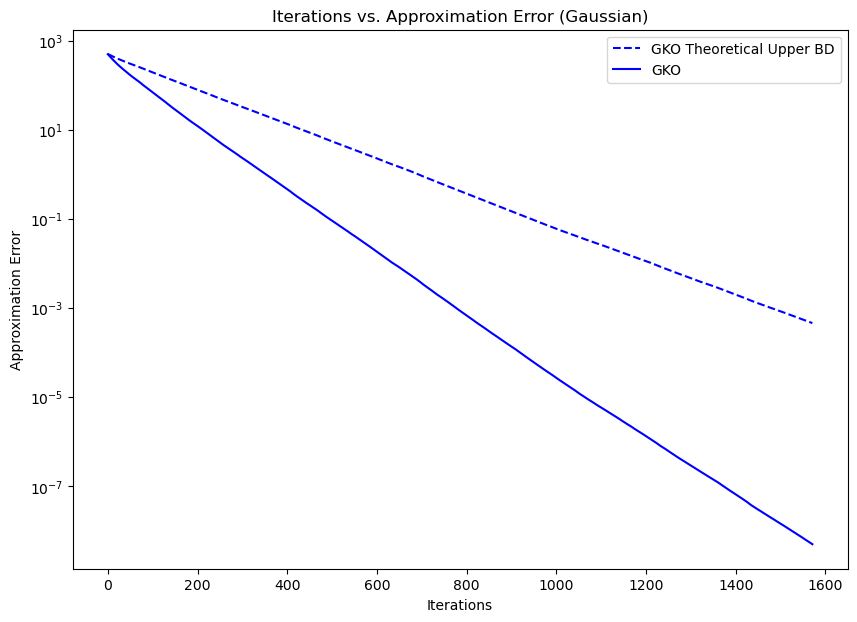

In [9]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gaussian[2])), gko_gaussian[2], linestyle = 'dashed', 
            color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gaussian[0]), gko_gaussian[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian)')
plt.legend()

In [48]:
i=0
for n in range(gko_gaussian[0]):
    if gko_gaussian[2] > gko_gaussian[1]:
        i+=1

gko_gaussian[0] == i

True

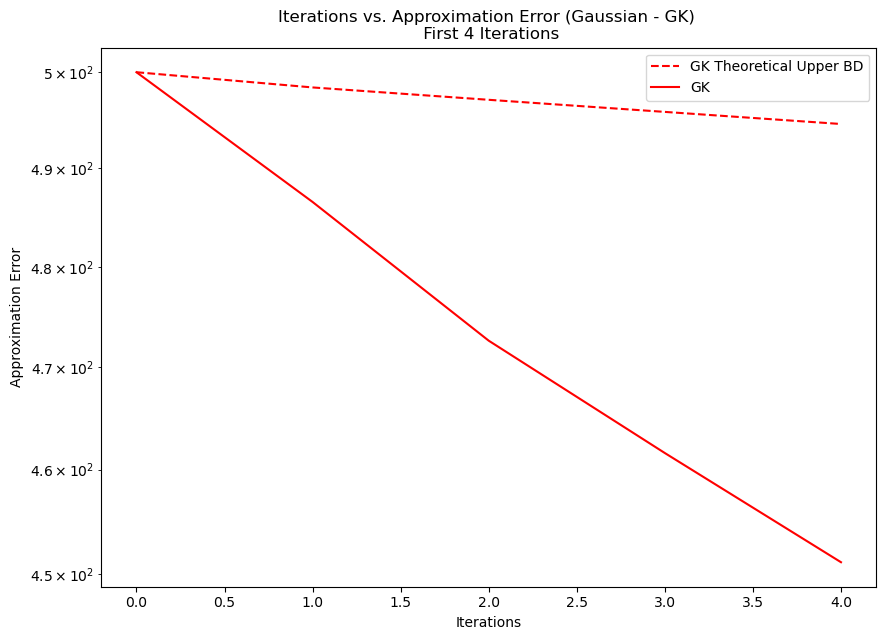

In [10]:
# Show GK empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gk_gaussian[2][0:5], linestyle = 'dashed', 
             color = "red", label = 'GK Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gk_gaussian[1][0:5], linestyle = 'solid', 
             color = "red", label = 'GK')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - GK) \n First 4 Iterations')
plt.legend()

In [59]:
gko_gaussian[1][0]

484.38962553536174

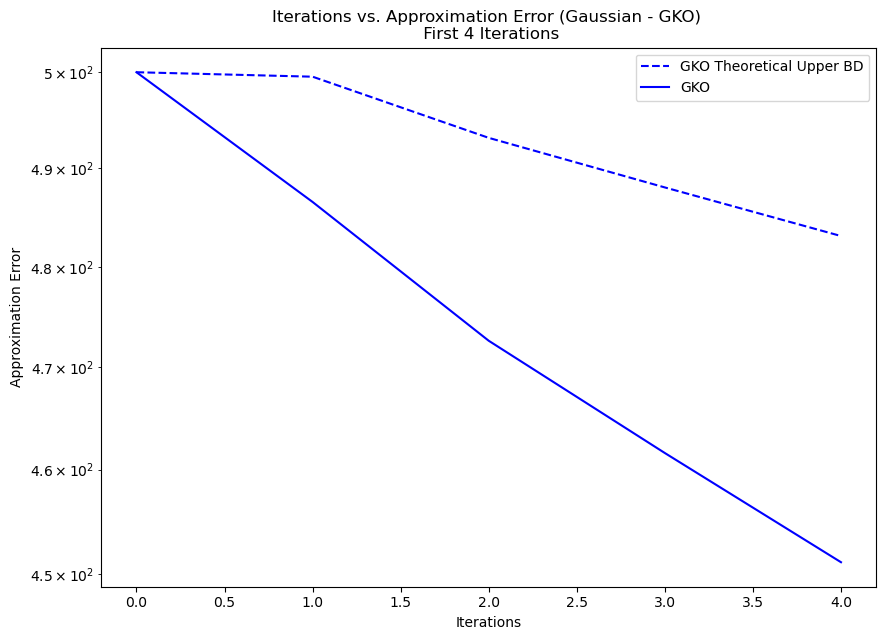

In [11]:
# Show GKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_gaussian[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_gaussian[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - GKO) \n First 4 Iterations')
plt.legend()

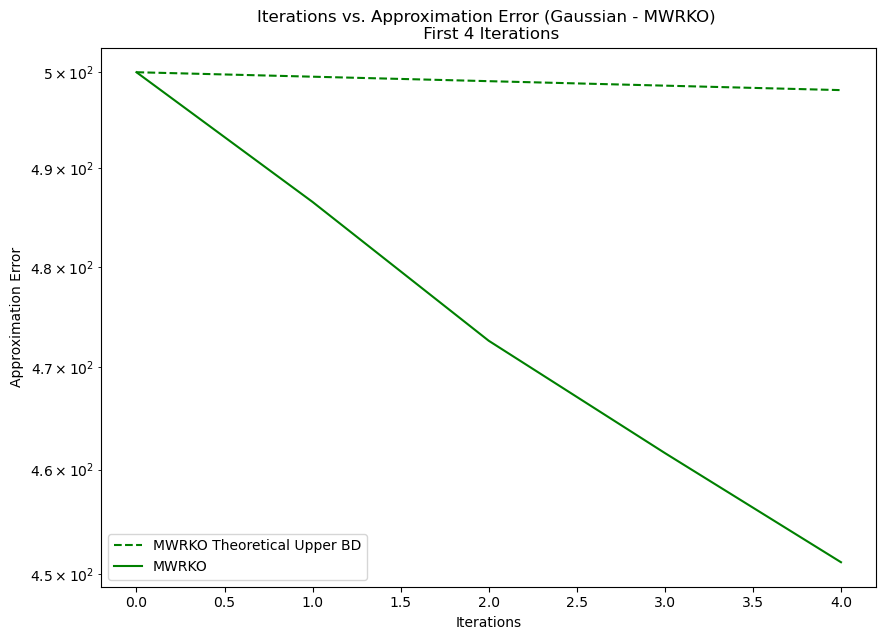

In [12]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gaussian[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gaussian[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - MWRKO) \n First 4 Iterations')
plt.legend()

In [52]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gaussian[0]-9), mwrko_gaussian[0]+1)))
# empirical result data
e_result = list(mwrko_gaussian[1][0:10])
e_result.extend(list(mwrko_gaussian[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gaussian[2][0:10])
t_result.extend(list(mwrko_gaussian[2][-11:-1]))
# create and print df
mwrko_gauss_df = pd.DataFrame()
mwrko_gauss_df['k'] = k
mwrko_gauss_df['Theoretical BD'] = t_result
mwrko_gauss_df['Empirical Results'] = e_result
mwrko_gauss_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.616000e+03,1.617000e+03,1.618000e+03,1.619000e+03,1.620000e+03,1.621000e+03,1.622000e+03,1.623000e+03,1.624000e+03,1.625000e+03
Theoretical BD,500.000000,499.531697,499.063739,498.596126,498.128951,497.662214,497.195914,496.730051,496.264624,495.799634,1.101246e+02,1.100214e+02,1.099184e+02,1.098154e+02,1.097125e+02,1.096097e+02,1.095070e+02,1.094044e+02,1.093019e+02,1.091994e+02
Empirical Results,484.389626,471.748151,461.530320,451.402757,441.636854,431.272879,421.884509,412.144380,402.745993,393.575710,5.744911e-09,5.648674e-09,5.569354e-09,5.486489e-09,5.411400e-09,5.336920e-09,5.263504e-09,5.190945e-09,5.121212e-09,5.049798e-09


## Uniform System

In [22]:
# setting up data
A = np.random.uniform(size =(5000,500), low = 0, high = 1)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [23]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [24]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk =  S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [25]:
# Run algorithms
gk_uniform = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_uniform = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_uniform = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

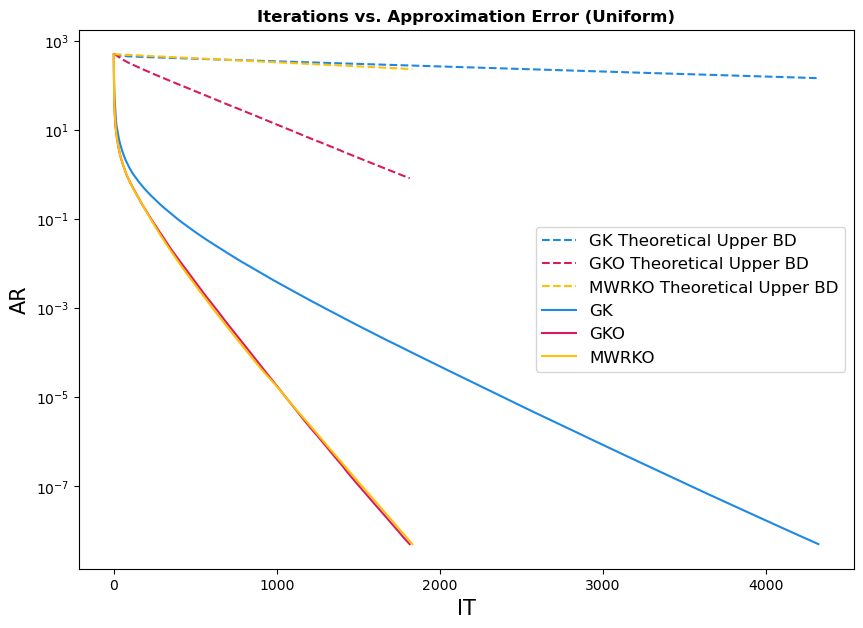

In [28]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_uniform[2])), gk_uniform[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(gko_uniform[2])), gko_uniform[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(mwrko_uniform[2])), mwrko_uniform[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
plt.semilogy(np.arange(gk_uniform[0]), gk_uniform[1], 
             color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
plt.semilogy(np.arange(gko_uniform[0]), gko_uniform[1], linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
plt.semilogy(np.arange(mwrko_uniform[0]), mwrko_uniform[1], linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
# labels
plt.xlabel('IT', fontsize = 15)
plt.ylabel('AR', fontsize = 15)
plt.title('Iterations vs. Approximation Error (Uniform)', fontweight="bold")
plt.legend(fontsize="12")
plt.show()

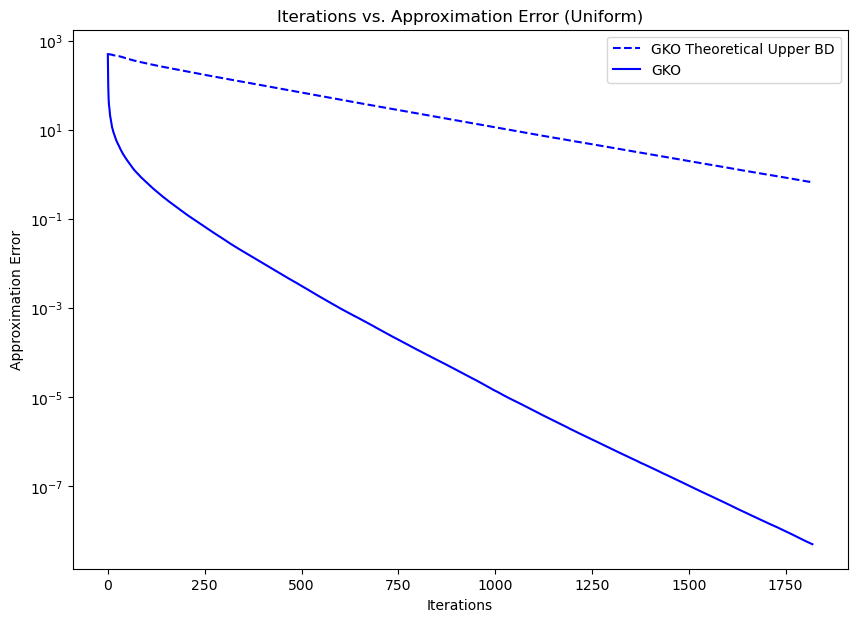

In [19]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_uniform[2])), gko_uniform[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_uniform[0]), gko_uniform[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform)')
plt.legend()

In [20]:
i=0
for n in range(gko_uniform[0]):
    if gko_uniform[2] > gko_uniform[1]:
        i+=1

gko_uniform[0] == i

True

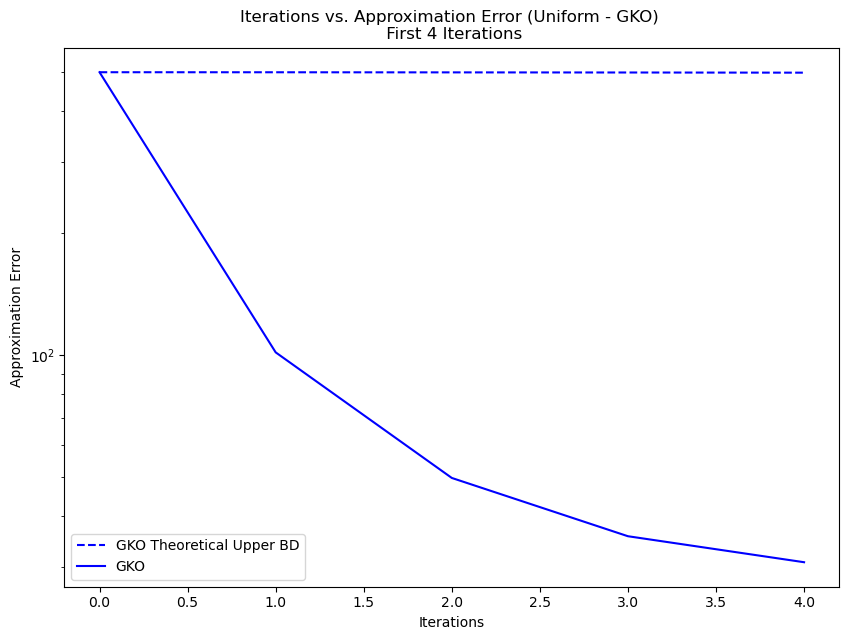

In [20]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_uniform[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_uniform[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform - GKO) \n First 4 Iterations')
plt.legend()

In [21]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_uniform[0]-9), mwrko_uniform[0]+1)))
# empirical result data
e_result = list(mwrko_uniform[1][0:10])
e_result.extend(list(mwrko_uniform[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_uniform[2][0:10])
t_result.extend(list(mwrko_uniform[2][-11:-1]))
# create and print df
mwrko_uniform_df = pd.DataFrame()
mwrko_uniform_df['k'] = k
mwrko_uniform_df['Theoretical BD'] = t_result
mwrko_uniform_df['Empirical Results'] = e_result
mwrko_uniform_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.0,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.823000e+03,1.824000e+03,1.825000e+03,1.826000e+03,1.827000e+03,1.828000e+03,1.829000e+03,1.830000e+03,1.831000e+03,1.832000e+03
Theoretical BD,500.0,499.882021,499.666307,499.450644,499.235074,499.019596,498.804212,498.588921,498.373723,498.158617,2.278446e+02,2.277462e+02,2.276479e+02,2.275497e+02,2.274515e+02,2.273533e+02,2.272552e+02,2.271571e+02,2.270590e+02,2.269610e+02
Empirical Results,500.0,101.532909,49.683799,36.645474,31.477157,25.672342,20.322907,18.787451,16.638287,14.787847,5.465282e-09,5.412942e-09,5.361811e-09,5.319724e-09,5.268942e-09,5.221495e-09,5.167957e-09,5.113587e-09,5.066641e-09,5.020424e-09


<Figure size 10000x5000 with 0 Axes>

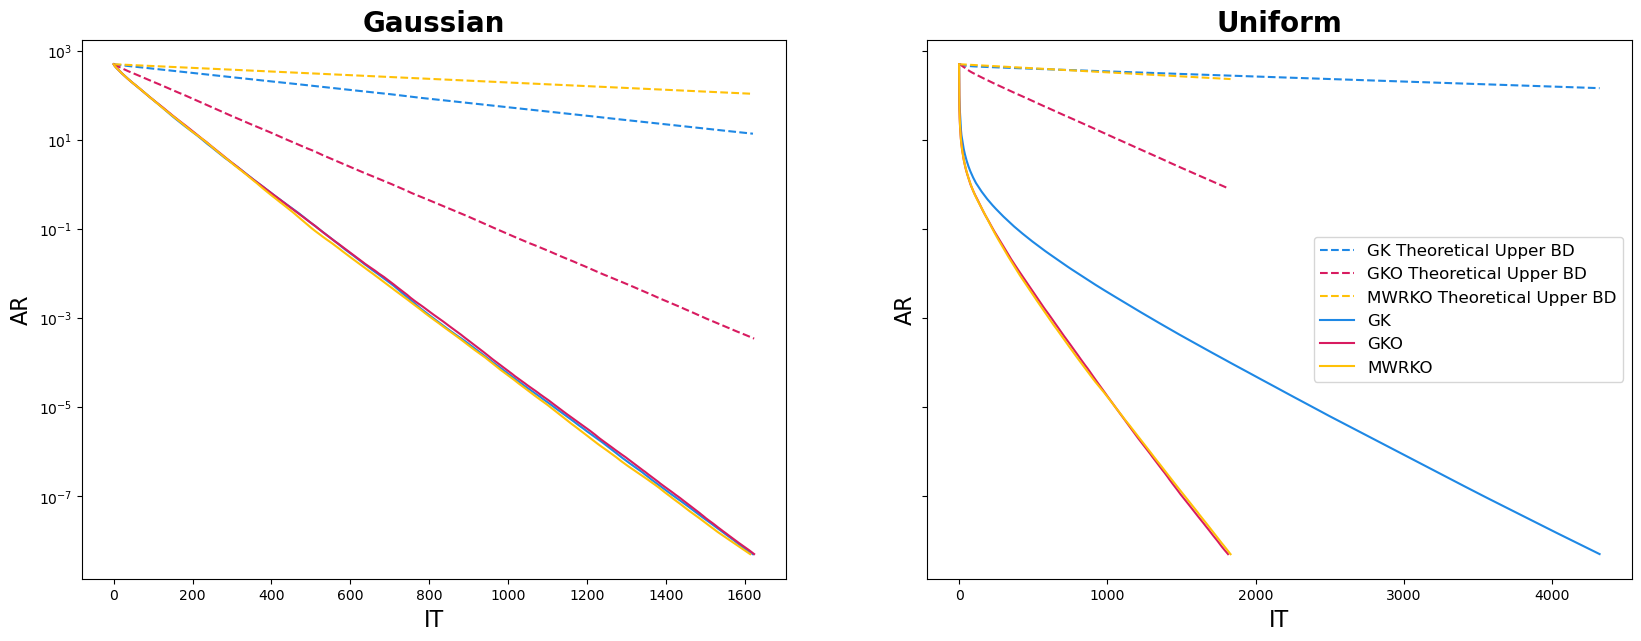

In [31]:
plt.figure(figsize=(100, 50))
fig, (ax1, ax2)  = plt.subplots(1, 2, sharey='row', figsize=(20, 7))
# plot theoretical bound
ax1.semilogy(np.arange(len(gk_gaussian[2])), gk_gaussian[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
ax1.semilogy(np.arange(len(gko_gaussian[2])), gko_gaussian[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
ax1.semilogy(np.arange(len(mwrko_gaussian[2])), mwrko_gaussian[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
ax1.semilogy(np.arange(gk_gaussian[0]), gk_gaussian[1], color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
ax1.semilogy(np.arange(gko_gaussian[0]), gko_gaussian[1], linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
ax1.semilogy(np.arange(mwrko_gaussian[0]), mwrko_gaussian[1], linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
# labels
ax1.set_title('Gaussian', fontsize=20, fontweight="bold")
ax1.set_xlabel('IT', fontsize=16)
ax1.set_ylabel('AR', fontsize=16)

#plt.title('Iterations vs. Approximation Error (Gaussian)', fontweight="bold")
#plt.legend(fontsize="15")
#plt.show()

# plot theoretical bound
ax2.semilogy(np.arange(len(gk_uniform[2])), gk_uniform[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
ax2.semilogy(np.arange(len(gko_uniform[2])), gko_uniform[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
ax2.semilogy(np.arange(len(mwrko_uniform[2])), mwrko_uniform[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
ax2.semilogy(np.arange(gk_uniform[0]), gk_uniform[1], 
             color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
ax2.semilogy(np.arange(gko_uniform[0]), gko_uniform[1], linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
ax2.semilogy(np.arange(mwrko_uniform[0]), mwrko_uniform[1], linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
# labels
ax2.set_title('Uniform', fontsize=20, fontweight="bold")
ax2.set_xlabel('IT', fontsize=16)
ax2.set_ylabel('AR', fontsize=16)

#plt.xlabel('IT', fontsize = 15)
#plt.ylabel('AR', fontsize = 15)
#plt.title('Iterations vs. Approximation Error (Uniform)', fontweight="bold")
plt.legend(fontsize="12")
#plt.show()

## 50/50 Gauss-Uniform System

In [32]:
# setting up data
A1 = np.random.rand(2500,500)
A2 = np.random.randn(2500,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [33]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [34]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [35]:
# Run algorithms
gk_gu1 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu1 = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu1 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

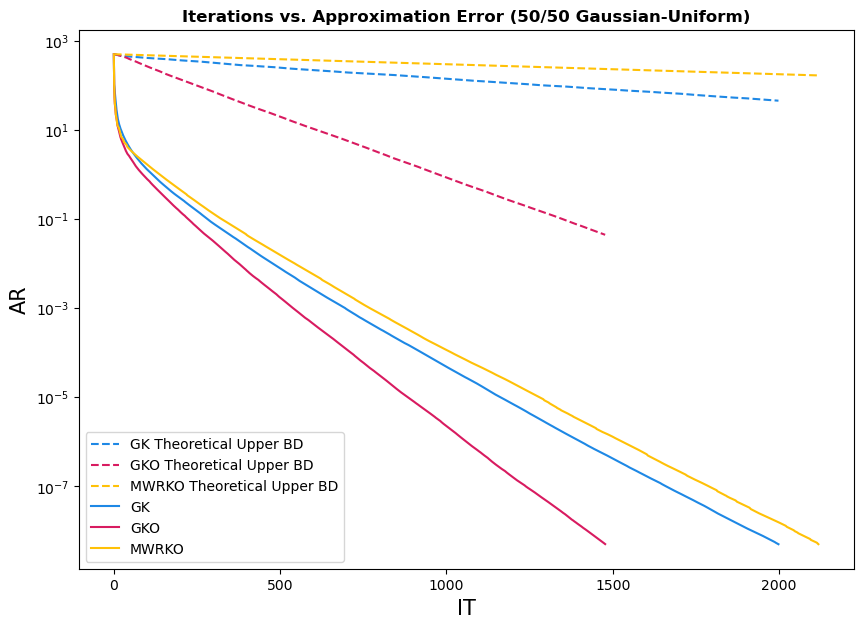

In [36]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu1[2])), gk_gu1[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(gko_gu1[2])), gko_gu1[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(mwrko_gu1[2])), mwrko_gu1[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
plt.semilogy(np.arange(gk_gu1[0]), gk_gu1[1], 
             color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
plt.semilogy(np.arange(gko_gu1[0]), gko_gu1[1], 
             linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
plt.semilogy(np.arange(mwrko_gu1[0]), mwrko_gu1[1], 
             linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
plt.xlabel('IT', fontsize = 15)
plt.ylabel('AR', fontsize = 15)
plt.title('Iterations vs. Approximation Error (50/50 Gaussian-Uniform)', fontweight="bold")
plt.legend()

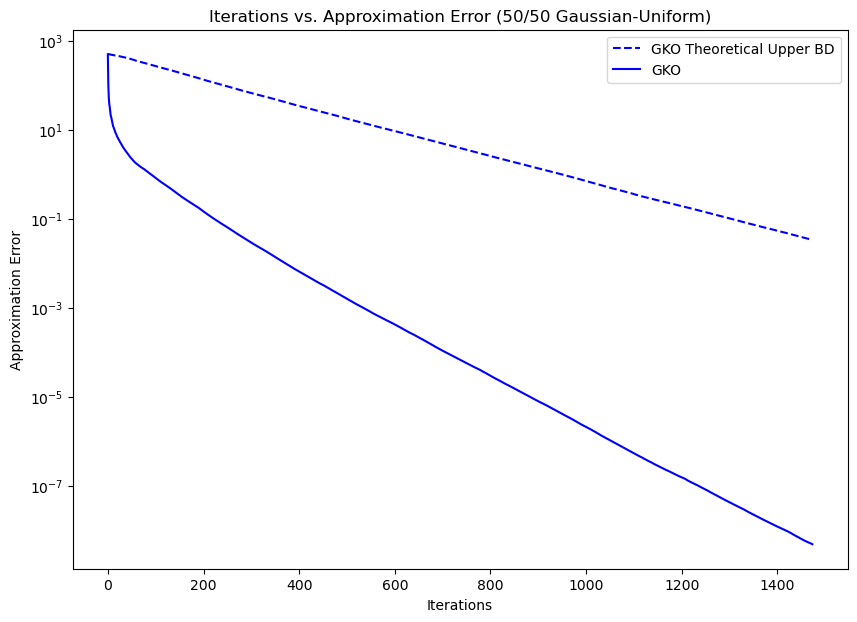

In [27]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gu1[2])), gko_gu1[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gu1[0]), gko_gu1[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gaussian-Uniform)')
plt.legend()

In [29]:
i=0
for n in range(gko_gu1[0]):
    if gko_gu1[2] > gko_gu1[1]:
        i+=1

gko_gu1[0] == i

True

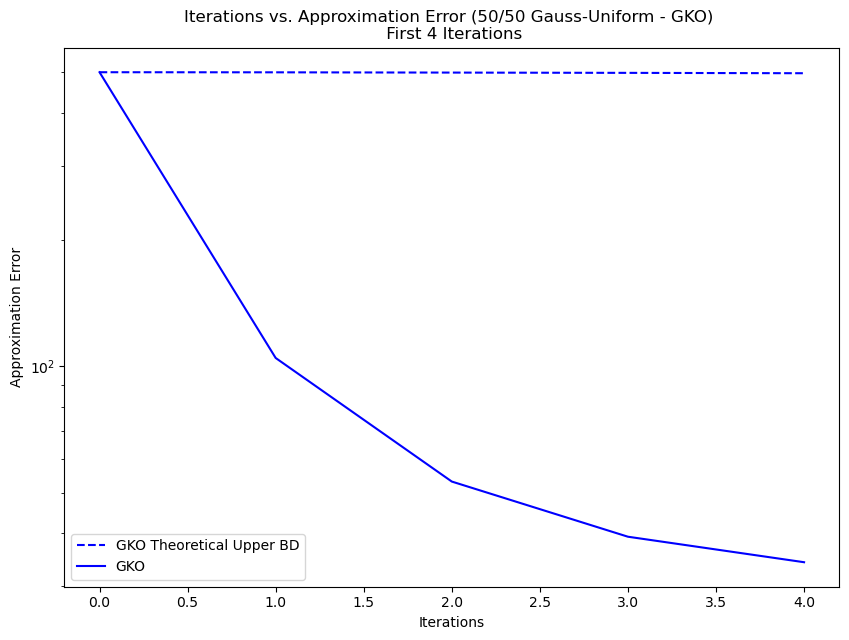

In [28]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_gu1[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gu1[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gauss-Uniform - GKO) \n First 4 Iterations')
plt.legend()

In [29]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu1[0]-9), mwrko_gu1[0]+1)))
# empirical result data
e_result = list(mwrko_gu1[1][0:10])
e_result.extend(list(mwrko_gu1[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu1[2][0:10])
t_result.extend(list(mwrko_gu1[2][-11:-1]))
# create and print df
mwrko_gu1_df = pd.DataFrame()
mwrko_gu1_df['k'] = k
mwrko_gu1_df['Theoretical BD'] = t_result
mwrko_gu1_df['Empirical Results'] = e_result
mwrko_gu1_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.0,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,2.120000e+03,2.121000e+03,2.122000e+03,2.123000e+03,2.124000e+03,2.125000e+03,2.126000e+03,2.127000e+03,2.128000e+03,2.129000e+03
Theoretical BD,500.0,499.737523,499.475131,499.212825,498.950656,498.688626,498.426732,498.164976,497.903358,497.641877,1.643534e+02,1.642671e+02,1.641808e+02,1.640946e+02,1.640084e+02,1.639223e+02,1.638362e+02,1.637502e+02,1.636642e+02,1.635782e+02
Empirical Results,500.0,104.552926,53.139492,39.286059,34.164590,27.736821,21.726907,19.866504,17.279928,15.145179,5.416912e-09,5.374888e-09,5.332018e-09,5.282960e-09,5.242744e-09,5.192332e-09,5.152781e-09,5.109601e-09,5.068538e-09,5.029843e-09


## 75/25 Gauss-Uniform System

In [37]:
# setting up data
A1 = np.random.rand(1250,500)
A2 = np.random.randn(3750,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [38]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [39]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [40]:
# Run algorithms
gk_gu2 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu2 = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu2 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

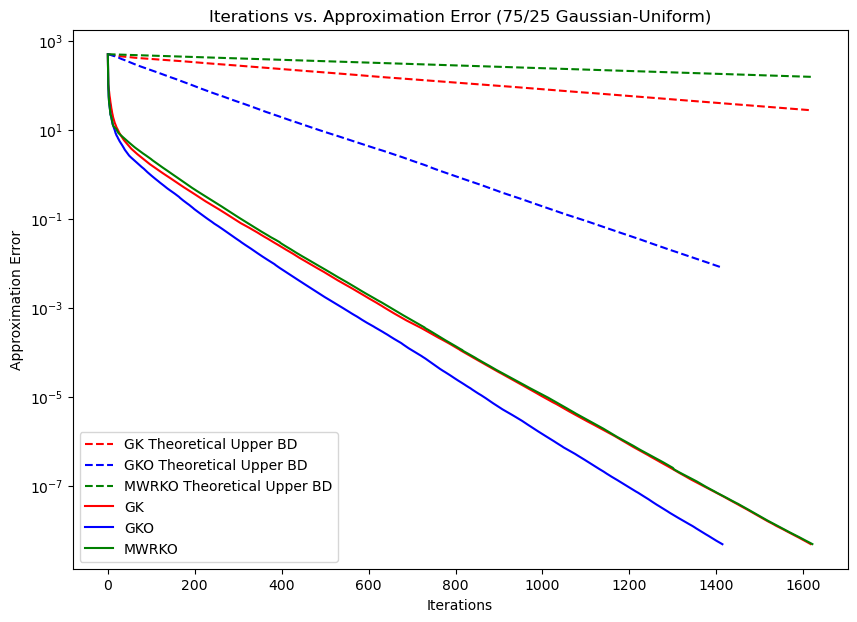

In [34]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu2[2])), gk_gu2[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu2[2])), gko_gu2[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu2[2])), mwrko_gu2[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu2[0]), gk_gu2[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu2[0]), gko_gu2[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu2[0]), mwrko_gu2[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gaussian-Uniform)')
plt.legend()

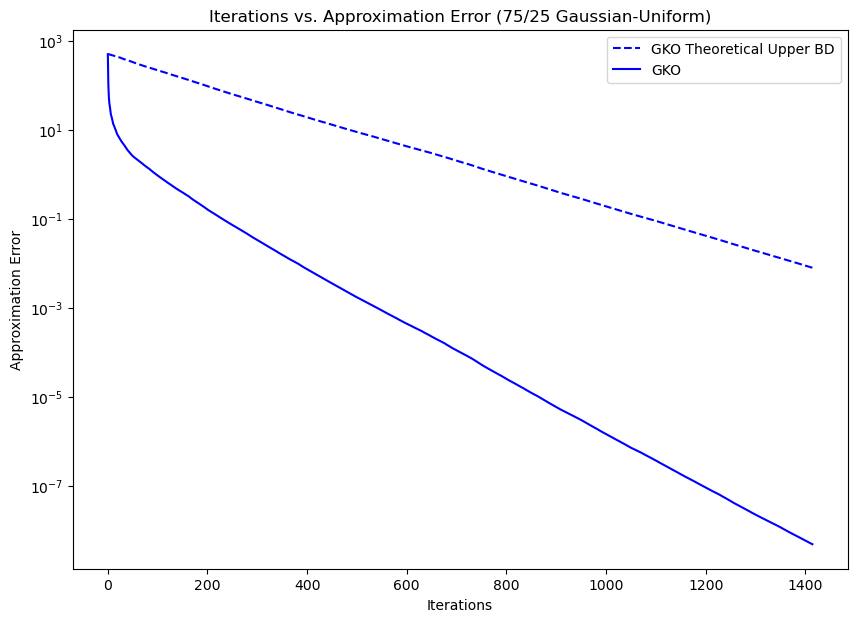

In [35]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gu2[2])), gko_gu2[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gu2[0]), gko_gu2[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gaussian-Uniform)')
plt.legend()

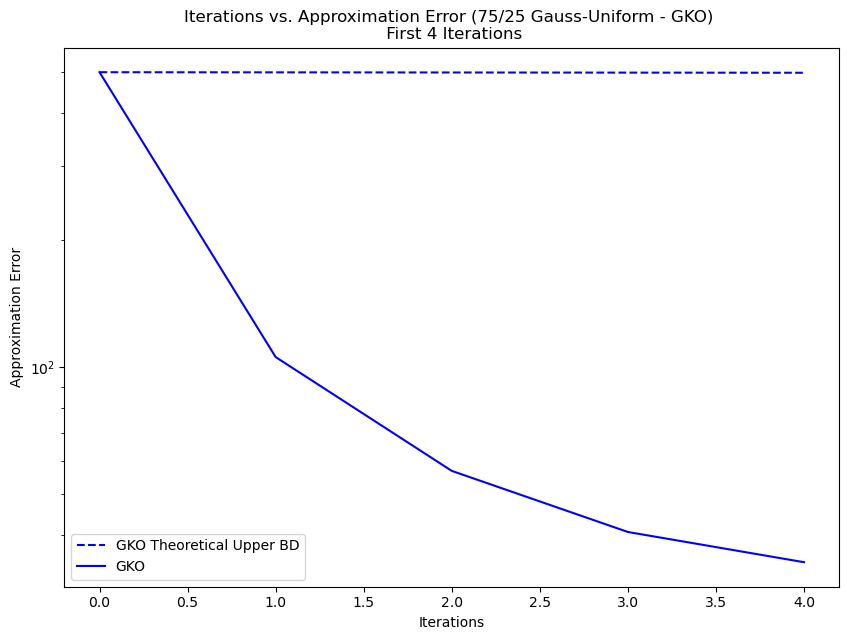

In [36]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gu2[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gu2[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gauss-Uniform - GKO) \n First 4 Iterations')
plt.legend()

In [37]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu2[0]-9), mwrko_gu2[0]+1)))
# empirical result data
e_result = list(mwrko_gu2[1][0:10])
e_result.extend(list(mwrko_gu2[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu2[2][0:10])
t_result.extend(list(mwrko_gu2[2][-11:-1]))
# create and print df
mwrko_gu2_df = pd.DataFrame()
mwrko_gu2_df['k'] = k
mwrko_gu2_df['Theoretical BD'] = t_result
mwrko_gu2_df['Empirical Results'] = e_result
mwrko_gu2_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.0,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.613000e+03,1.614000e+03,1.615000e+03,1.616000e+03,1.617000e+03,1.618000e+03,1.619000e+03,1.620000e+03,1.621000e+03,1.622000e+03
Theoretical BD,500.0,499.638762,499.277713,498.916852,498.556252,498.195913,497.835834,497.476016,497.116457,496.757159,1.559932e+02,1.558805e+02,1.557678e+02,1.556552e+02,1.555427e+02,1.554303e+02,1.553180e+02,1.552057e+02,1.550935e+02,1.549814e+02
Empirical Results,500.0,105.720647,56.817494,40.714476,34.527303,28.188309,21.904865,21.151644,19.401755,17.297298,5.592011e-09,5.525645e-09,5.466925e-09,5.406868e-09,5.344335e-09,5.284585e-09,5.227667e-09,5.161489e-09,5.099725e-09,5.035600e-09


## 25/75 Gauss-Uniform System

In [41]:
# setting up data
A1 = np.random.rand(3750,500)
A2 = np.random.randn(1250,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [42]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [43]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [44]:
# Run algorithms
gk_gu3 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu3 = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu3 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

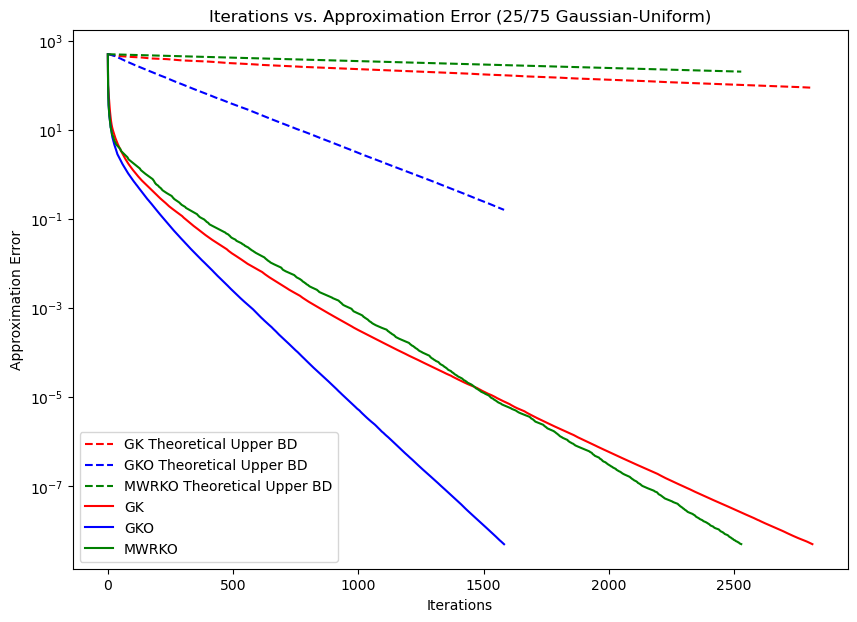

In [42]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu3[2])), gk_gu3[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu3[2])), gko_gu3[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu3[2])), mwrko_gu3[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu3[0]), gk_gu3[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu3[0]), gko_gu3[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu3[0]), mwrko_gu3[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gaussian-Uniform)')
plt.legend()

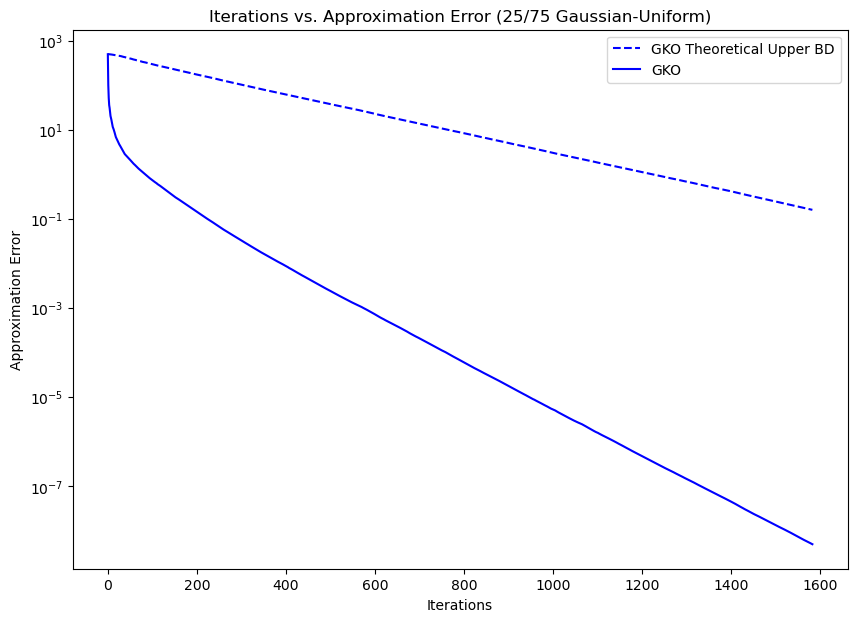

In [43]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_gu3[2])), gko_gu3[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_gu3[0]), gko_gu3[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gaussian-Uniform)')
plt.legend()

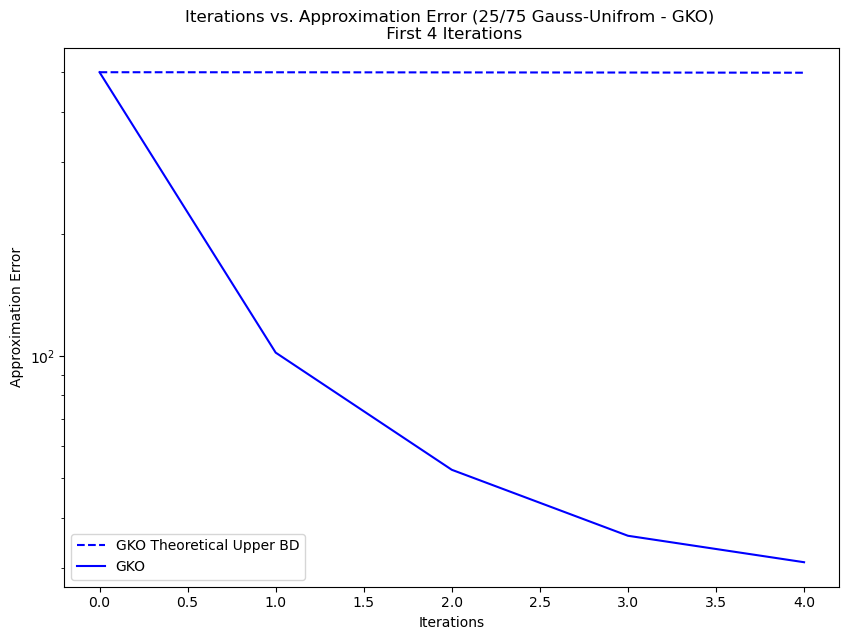

In [44]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_gu3[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_gu3[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gauss-Unifrom - GKO) \n First 4 Iterations')
plt.legend()

In [45]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu3[0]-9), mwrko_gu3[0]+1)))
# empirical result data
e_result = list(mwrko_gu3[1][0:10])
e_result.extend(list(mwrko_gu3[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu3[2][0:10])
t_result.extend(list(mwrko_gu3[2][-11:-1]))
# create and print df
mwrko_gu3_df = pd.DataFrame()
mwrko_gu3_df['k'] = k
mwrko_gu3_df['Theoretical BD'] = t_result
mwrko_gu3_df['Empirical Results'] = e_result
mwrko_gu3_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.0,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,2.521000e+03,2.522000e+03,2.523000e+03,2.524000e+03,2.525000e+03,2.526000e+03,2.527000e+03,2.528000e+03,2.529000e+03,2.530000e+03
Theoretical BD,500.0,499.822198,499.644424,499.466678,499.288995,499.111375,498.933818,498.756324,498.578894,498.401526,2.040419e+02,2.039693e+02,2.038967e+02,2.038242e+02,2.037517e+02,2.036792e+02,2.036067e+02,2.035343e+02,2.034619e+02,2.033895e+02
Empirical Results,500.0,101.919409,52.462521,36.834754,31.525988,26.008316,20.982497,19.216882,17.076863,15.198752,5.415547e-09,5.339087e-09,5.264442e-09,5.231035e-09,5.162244e-09,5.129016e-09,5.101318e-09,5.074293e-09,5.048000e-09,5.021688e-09


<Figure size 10000x5000 with 0 Axes>

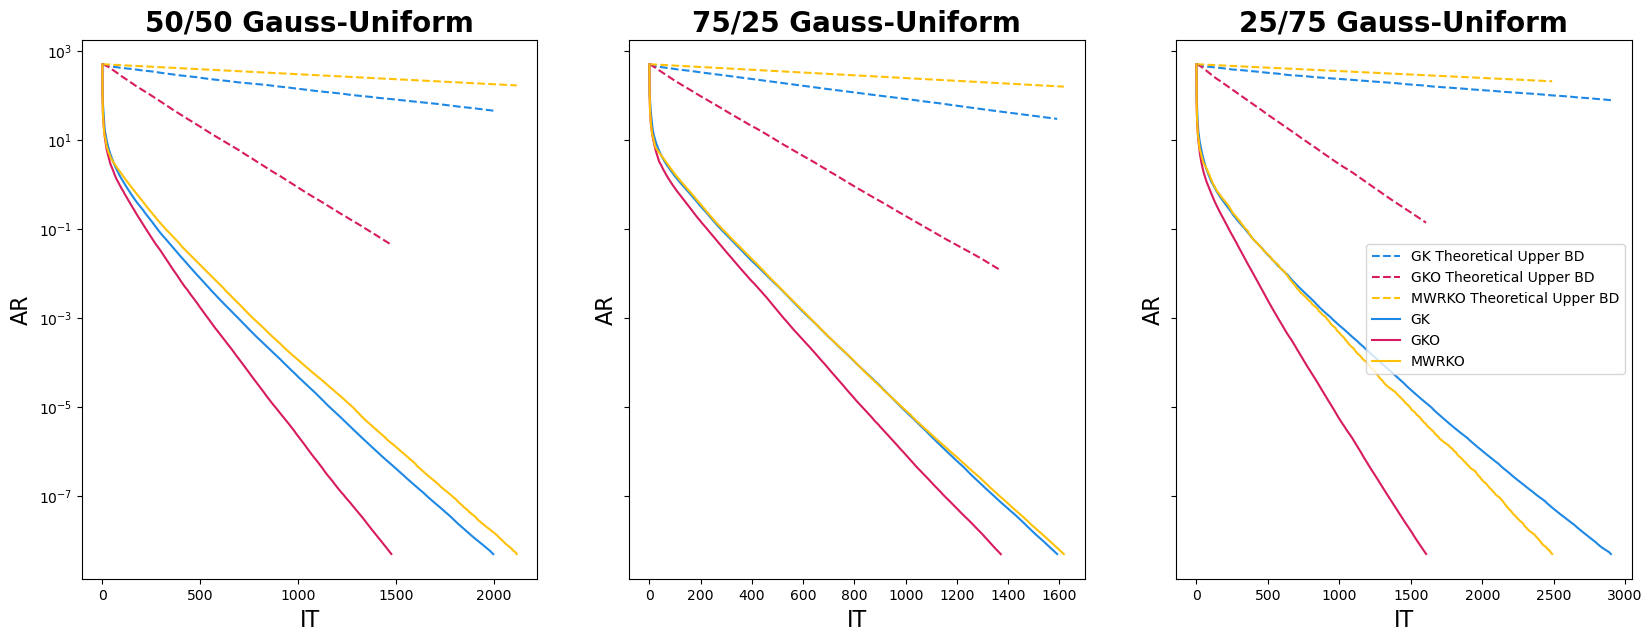

In [45]:
plt.figure(figsize=(100, 50))
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, sharey='row', figsize=(20, 7))

# plot theoretical bound
ax1.semilogy(np.arange(len(gk_gu1[2])), gk_gu1[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
ax1.semilogy(np.arange(len(gko_gu1[2])), gko_gu1[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
ax1.semilogy(np.arange(len(mwrko_gu1[2])), mwrko_gu1[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
ax1.semilogy(np.arange(gk_gu1[0]), gk_gu1[1], 
             color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
ax1.semilogy(np.arange(gko_gu1[0]), gko_gu1[1], 
             linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
ax1.semilogy(np.arange(mwrko_gu1[0]), mwrko_gu1[1], 
             linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
ax1.set_title('50/50 Gauss-Uniform', fontsize=20, fontweight="bold")
ax1.set_xlabel('IT', fontsize=16)
ax1.set_ylabel('AR', fontsize=16)

# plot theoretical bound
ax2.semilogy(np.arange(len(gk_gu2[2])), gk_gu2[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
ax2.semilogy(np.arange(len(gko_gu2[2])), gko_gu2[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
ax2.semilogy(np.arange(len(mwrko_gu2[2])), mwrko_gu2[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
ax2.semilogy(np.arange(gk_gu2[0]), gk_gu2[1], 
             color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
ax2.semilogy(np.arange(gko_gu2[0]), gko_gu2[1], 
             linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
ax2.semilogy(np.arange(mwrko_gu2[0]), mwrko_gu2[1], 
             linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
ax2.set_title('75/25 Gauss-Uniform', fontsize=20, fontweight="bold")
ax2.set_xlabel('IT', fontsize=16)
ax2.set_ylabel('AR', fontsize=16)

# plot theoretical bound
ax3.semilogy(np.arange(len(gk_gu3[2])), gk_gu3[2], color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
ax3.semilogy(np.arange(len(gko_gu3[2])), gko_gu3[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
ax3.semilogy(np.arange(len(mwrko_gu3[2])), mwrko_gu3[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
ax3.semilogy(np.arange(gk_gu3[0]), gk_gu3[1], 
             color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
ax3.semilogy(np.arange(gko_gu3[0]), gko_gu3[1], 
             linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
ax3.semilogy(np.arange(mwrko_gu3[0]), mwrko_gu3[1], 
             linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
ax3.set_title('25/75 Gauss-Uniform', fontsize=20, fontweight="bold")
ax3.set_xlabel('IT', fontsize=16)
ax3.set_ylabel('AR', fontsize=16)

plt.legend()

## Two Highly Correlated Systems

In [46]:
# setting up data
# Step 1: generate two gaussian linear system
A = np.random.randn(2,500)
A1 = np.reshape(A[0,:], (1, 500))
A2 = np.reshape(A[1,:], (1, 500))
# Step 2: generate correalted systems
U = np.random.uniform(low = 0, high = 1, size  = (2500,500))
A1 =  np.tile(A1, (2500, 1)) +  U
A2 =  np.tile(A2, (2500, 1)) +  U
# Step 3: Combine two correlated systems
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [47]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = S2_min / 4
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [48]:
# Run algorithms
gk_corr = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_corr = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_corr = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

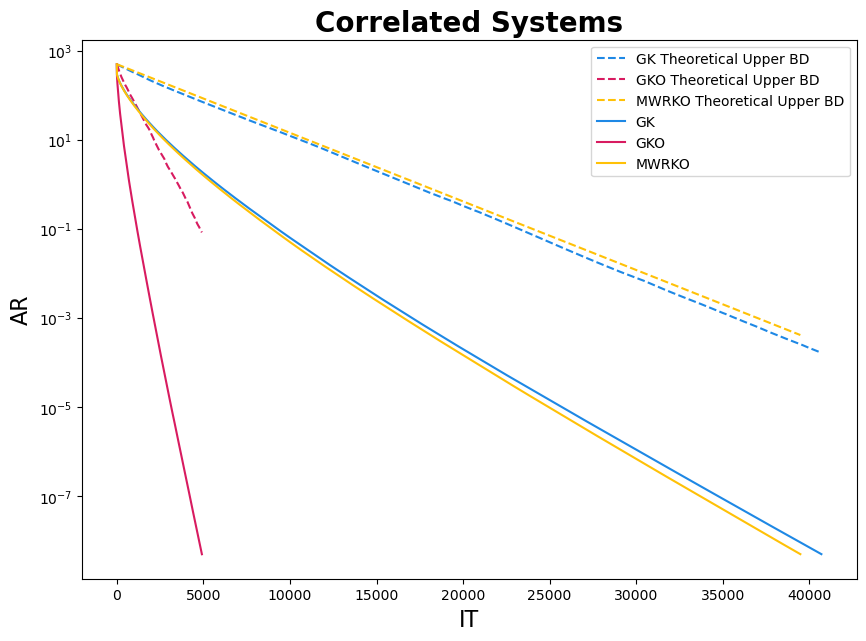

In [53]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_corr[2])), gk_corr[2], 
             color = '#1E88E5', linestyle = 'dashed'
             , label = 'GK Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(gko_corr[2])), gko_corr[2], linestyle = 'dashed', 
            color = '#D81B60', label = 'GKO Theoretical Upper BD', linewidth = 1.5)
plt.semilogy(np.arange(len(mwrko_corr[2])), mwrko_corr[2], linestyle = 'dashed', 
             color = '#FFC107', label = 'MWRKO Theoretical Upper BD', linewidth = 1.5)
# plot empirical results
plt.semilogy(np.arange(gk_corr[0]), gk_corr[1], 
             color = '#1E88E5', linestyle = 'solid', label = 'GK', linewidth = 1.5)
plt.semilogy(np.arange(gko_corr[0]), gko_corr[1], 
             linestyle = 'solid', color = '#D81B60', label = 'GKO', linewidth = 1.5)
plt.semilogy(np.arange(mwrko_corr[0]), mwrko_corr[1], 
             linestyle = 'solid', color = '#FFC107', label = 'MWRKO', linewidth = 1.5)
plt.xlabel('IT', fontsize=16)
plt.ylabel('AR', fontsize=16)
plt.title('Correlated Systems', fontweight="bold", fontsize=20)
plt.legend()

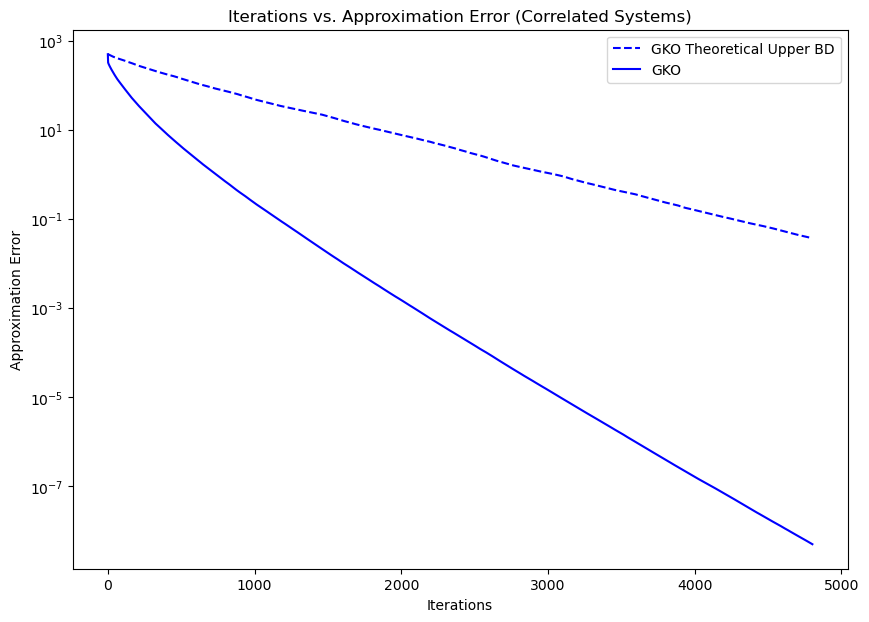

In [51]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gko_corr[2])), gko_corr[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(gko_corr[0]), gko_corr[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems)')
plt.legend()

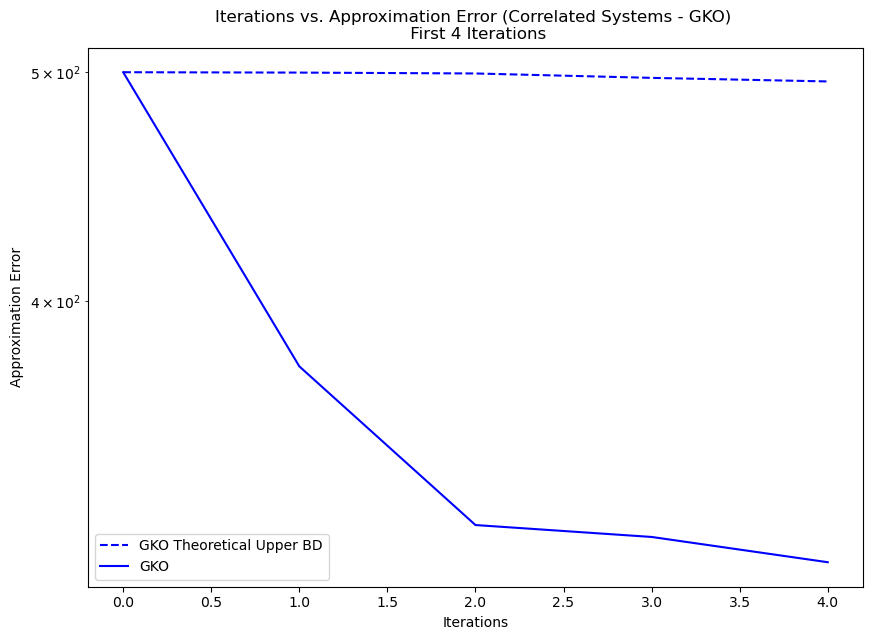

In [52]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_corr[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_corr[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems - GKO) \n First 4 Iterations')
plt.legend()

In [53]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_corr[0]-9), mwrko_corr[0]+1)))
# empirical result data
e_result = list(mwrko_corr[1][0:10])
e_result.extend(list(mwrko_corr[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_corr[2][0:10])
t_result.extend(list(mwrko_corr[2][-11:-1]))
# create and print df
mwrko_corr_df = pd.DataFrame()
mwrko_corr_df['k'] = k
mwrko_corr_df['Theoretical BD'] = t_result
mwrko_corr_df['Empirical Results'] = e_result
mwrko_corr_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.0,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,3.494300e+04,3.494400e+04,3.494500e+04,3.494600e+04,3.494700e+04,3.494800e+04,3.494900e+04,3.495000e+04,3.495100e+04,3.495200e+04
Theoretical BD,500.0,499.822198,499.644424,499.466678,499.288995,499.111375,498.933818,498.756324,498.578894,498.401526,1.993791e-03,1.993082e-03,1.992373e-03,1.991664e-03,1.990955e-03,1.990247e-03,1.989539e-03,1.988831e-03,1.988124e-03,1.987416e-03
Empirical Results,500.0,375.304647,321.504700,320.766534,319.019075,317.384261,315.794838,314.251276,312.784229,311.380496,5.029868e-09,5.026659e-09,5.023401e-09,5.020142e-09,5.016904e-09,5.013672e-09,5.010445e-09,5.007223e-09,5.004024e-09,5.000833e-09
